In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm

from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import pickle

In [3]:
path = Path('/project/data/out/NIMH-CHEFS')

imagePaths = list(path.rglob('*.jpg'))
imagePaths_str = [str(path) for path in imagePaths]

#### Show samples

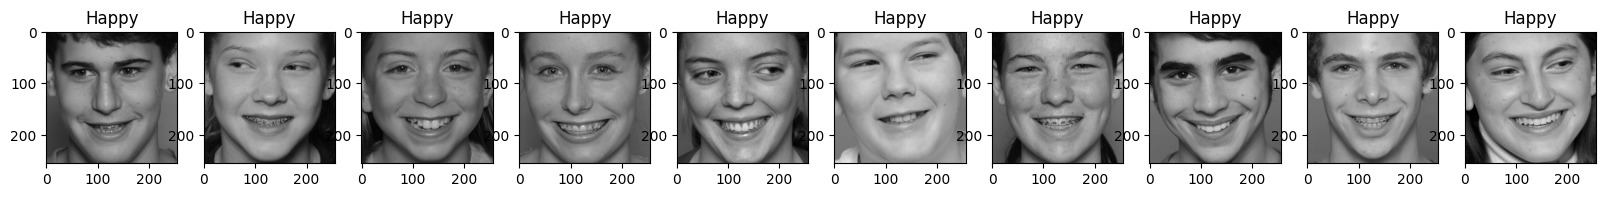

In [4]:
fig = plt.figure(figsize=(20,20))

for i in range(10):

    fig.add_subplot(1, 10, i + 1)
    plt.imshow(np.array(cv2.imread(str(imagePaths[i]))), cmap='gray')
    label = Path(imagePaths[i]).parent.name
    plt.title(label)

plt.show()

In [5]:
def to_grayscale(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def resize_image(img, size):
    return cv2.resize(img, (size,size))

In [18]:
def featuresHog(imagePaths):

    data = []
    labels = []

    for p in tqdm(imagePaths):
        im = to_grayscale(p)
        im = resize_image(im, 64)
        
        # extract hog feature descriptor
        """ fd1 = hog(im, orientations=7, pixels_per_cell=(8, 8),
                  cells_per_block=(4, 4), 
                  block_norm='L2-Hys',
                  transform_sqrt=False, 
                  feature_vector=True) """

        label = Path(p).parent.name
        labels.append(label)
        data.append(im.flatten())

    data = np.array(data)
    labels = np.array(labels)
    return data, labels
  

In [19]:
def print_score(clf, x_train, y_train, x_test, y_test, train=True):
    if train:
        y_prediction = clf.predict(x_train)
        clf_report = classification_report(y_train, y_prediction)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, y_prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, y_prediction)}\n")
        
    elif train==False:
        y_prediction = clf.predict(x_test)
        clf_report = classification_report(y_test, y_prediction)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, y_prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_prediction)}\n")



In [20]:
data, labels = featuresHog(imagePaths_str)

print("Number of features ..." + str(data.shape[1]), "\n", "Number of labels ..." + str(labels.shape[0]))


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 532/532 [00:00<00:00, 698.98it/s]

Number of features ...4096 
 Number of labels ...532


In [22]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42)
print(f"Number of images used in training: {x_train.shape[0]}\n", f"Number of images used in testing: {x_test.shape[0]}")


classifier = SVC()
parameters = [{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}]

Number of images used in training: 425
 Number of images used in testing: 107


### Grid Search

In [23]:
grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_estimator = grid_search.best_estimator_
pickle.dump(best_estimator, open('/project/data/model.p', 'wb'))

In [24]:
print_score(best_estimator, x_train, y_train, x_test, y_test, train=True)
print_score(best_estimator, x_train, y_train, x_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Afraid       1.00      1.00      1.00        84
       Angry       1.00      1.00      1.00        83
       Happy       1.00      1.00      1.00        86
     Neutral       1.00      1.00      1.00        89
         Sad       1.00      1.00      1.00        83

    accuracy                           1.00       425
   macro avg       1.00      1.00      1.00       425
weighted avg       1.00      1.00      1.00       425

_______________________________________________
Confusion Matrix: 
 [[84  0  0  0  0]
 [ 0 83  0  0  0]
 [ 0  0 86  0  0]
 [ 0  0  0 89  0]
 [ 0  0  0  0 83]]

Test Result:
Accuracy Score: 21.50%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Afraid       0.00      0.00      0.00        21
       Angry       0.00   

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### K-fold cross validation

In [25]:
n_splits_values = [3, 5, 10]

In [26]:
for n_splits in n_splits_values:
    cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    scores = cross_val_score(best_estimator, data, labels, scoring='accuracy', cv=cv, n_jobs=-1)
    print(f"{n_splits}-Fold CV: {scores.mean():.2f} accuracy with a standard deviation of {scores.std():.2f}")

3-Fold CV: 0.16 accuracy with a standard deviation of 0.02
5-Fold CV: 0.17 accuracy with a standard deviation of 0.04
10-Fold CV: 0.17 accuracy with a standard deviation of 0.05


### Sample classification

Only for illustration purposes. Training data was used 

In [ ]:
model_path = '/project/data/model.p'
with open(model_path, 'rb') as model_file:
    model = pickle.load(model_file)

def classify_image(p, model):
    img = to_grayscale(p)
    img = resize_image(img, 64)
        
    fd1 = hog(img, orientations=7, pixels_per_cell=(8, 8),
                cells_per_block=(4, 4), 
                block_norm='L2-Hys',
                transform_sqrt=False, 
                feature_vector=True)
    
    fd1 = fd1.reshape(1, -1)
    
    prediction = model.predict(fd1)
    
    categories = labels.tolist()
    
    return prediction[0]


path = '/project/data/DSC_4644.jpg' 
predicted_category = classify_image(path, model)
print(f'The input image is classified as: {predicted_category}')
